In [25]:
import os
import numpy as np
import pandas as pd
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
# 1. Загрузка и предварительная обработка
os.chdir('/home/konnilol/Documents/uni/mmo/pr7')
data = pd.read_csv('penguins.csv')

print("Raw shape:", data.shape)
print("Columns:", data.columns.tolist())


Raw shape: (344, 5)
Columns: ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']


In [27]:
# Уберём явные выбросы и строки с NA
df = data.copy()

# flipper_length_mm
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g'])

# отфильтруем по разумному диапазону длины ласт (150–250 мм)
df = df['flipper_length_mm'] < 350

print("Cleaned shape:", df.shape)


Cleaned shape: (342,)


In [28]:
# Сохраним пол/sex для интерпретации, если есть
sex = None
if 'sex' in df.columns:
    sex = df['sex'].values
    print("Unique sex values:", pd.Series(sex).value_counts())


AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
# 2. Формируем матрицу признаков и нормализуем (StandardScaler)
features = ['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']
X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nAfter scaling:")
print("Mean (approx):", X_scaled.mean(axis=0).round(3))
print("Std (approx):", X_scaled.std(axis=0).round(3))



After scaling:
Mean (approx): [ 0.  0. -0. -0.]
Std (approx): [1. 1. 1. 1.]


In [ ]:
# 3. Обучение SOM (сеть Кохонена)
som_x, som_y = 2, 1
som = MiniSom(x=som_x, y=som_y, input_len=X_scaled.shape[1],
              sigma=1.0, learning_rate=0.5,
              neighborhood_function='gaussian',
              random_seed=42)

som.random_weights_init(X_scaled)
som.train_random(X_scaled, num_iteration=500)  # итераций при необходимости увеличить


In [ ]:
# 4. Получение кластеров из SOM
# Для каждого объекта находим BMU (best matching unit)
bmus = np.array([som.winner(x) for x in X_scaled])

# Кодируем BMU в одномерный индекс кластера
cluster_labels = np.array([bx * som_y + by for (bx, by) in bmus])

n_clusters = len(np.unique(cluster_labels))
print(f"\nSOM clusters (unique BMUs used): {n_clusters}")



SOM clusters (unique BMUs used): 2


In [ ]:
# 5. Оценка качества кластеризации (по признакам X_scaled)
if n_clusters > 1 and n_clusters < X_scaled.shape[0]:
    sil = silhouette_score(X_scaled, cluster_labels)
    print(f"Silhouette (SOM clusters): {sil:.4f}")
else:
    sil = np.nan
    print("Silhouette не считается (меньше 2 кластеров или каждый объект в своём кластере).")


Silhouette (SOM clusters): 0.5322


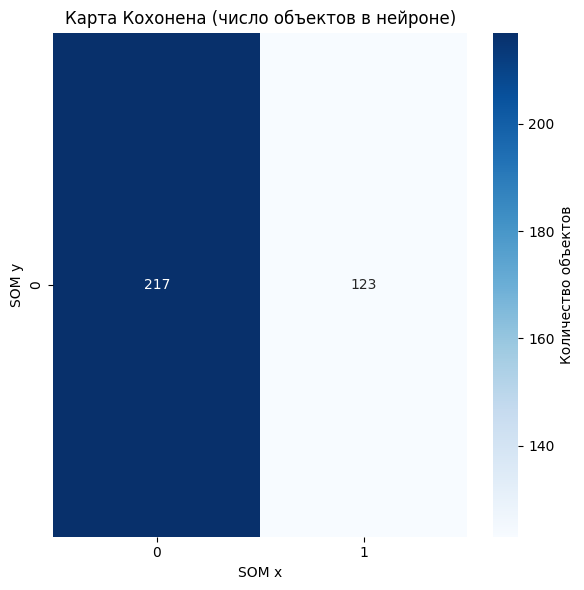

In [ ]:
plt.figure(figsize=(6, 6))
# Создадим матрицу частот попадания объектов в каждый нейрон
hit_map = np.zeros((som_x, som_y), dtype=int)
for (bx, by) in bmus:
    hit_map[bx, by] += 1

sns.heatmap(hit_map.T, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label': 'Количество объектов'})
plt.title('Карта Кохонена (число объектов в нейроне)')
plt.xlabel('SOM x')
plt.ylabel('SOM y')
plt.tight_layout()
plt.show()


<positron-console-cell-22>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


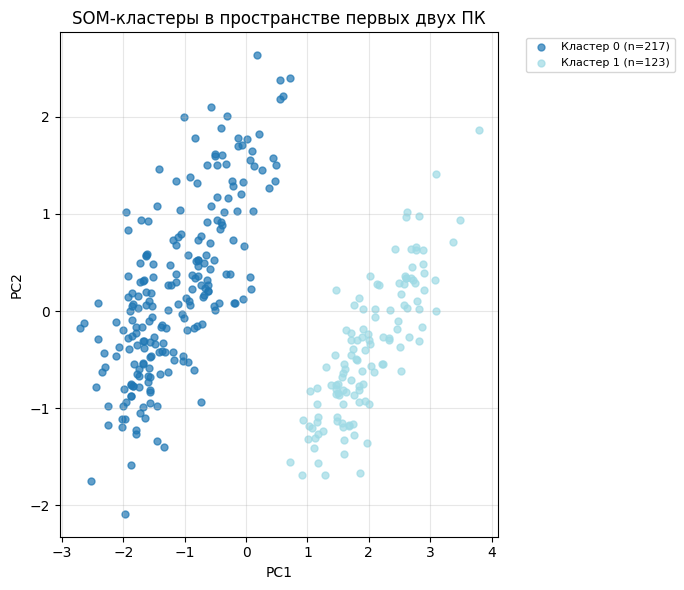

In [ ]:
# 7. Визуализация объектов в признаковом пространстве (PCA + кластеры SOM)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 6))
uniq = np.unique(cluster_labels)
cmap = plt.cm.get_cmap('tab20', len(uniq))

for i, cl in enumerate(uniq):
    mask = cluster_labels == cl
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                s=25, alpha=0.7, color=cmap(i),
                label=f'Кластер {cl} (n={mask.sum()})')

plt.title('SOM-кластеры в пространстве первых двух ПК')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# 8. Интерпретация кластеров через средние значения признаков

cluster_stats = df.copy()
cluster_stats['som_cluster'] = cluster_labels

cluster_profile = cluster_stats.groupby('som_cluster')[features].mean().round(2)
cluster_counts = cluster_stats['som_cluster'].value_counts().sort_index()

print("\nРазмеры SOM-кластеров:")
print(cluster_counts)

print("\nСредние значения признаков по SOM-кластерам:")
print(cluster_profile)

if sex is not None:
    sex_series = df.copy()
    sex_series['som_cluster'] = cluster_labels
    sex_dist = sex_series.groupby('som_cluster')['sex'].value_counts(normalize=True).round(2)
    print("\nРаспределение пола по SOM-кластерам (доли):")
    print(sex_dist)



Размеры SOM-кластеров:
som_cluster
0    217
1    123
Name: count, dtype: int64

Средние значения признаков по SOM-кластерам:
             culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
som_cluster                                                                   
0                       41.94            18.35             191.76      3705.07
1                       47.50            14.98             217.19      5076.02

Распределение пола по SOM-кластерам (доли):
som_cluster  sex   
0            FEMALE    0.50
             MALE      0.50
1            MALE      0.51
             FEMALE    0.48
             .         0.01
Name: proportion, dtype: float64


### кластеризация прошла успешно. Все записи были присвоены в правильный кластер (кроме выбросов которые я просто убрал) 